In [1]:
import pyedflib
import numpy as np
import pandas as pd
%matplotlib inline
import os
import mne
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import networkx as nx
import sails
import connectivipy as cp

# Question 1
## 1.1

In [2]:
#read the data for eyes opened (EO)
f = pyedflib.EdfReader('S040R01.edf') #read the file
n = f.signals_in_file #number of signals (64)
signal_labels = f.getSignalLabels() #name of the signals
eo = np.zeros((n, f.getNSamples()[0])) #create a empty array
for i in np.arange(n):
    eo[i, :] = f.readSignal(i)  #fill up the arrays with the signal from the edf file

#read data for eyes closed (EC)
f = pyedflib.EdfReader('S040R02.edf')
n = f.signals_in_file
signal_labels = f.getSignalLabels()
ec = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    ec[i, :] = f.readSignal(i)

We compute the connections with the PDC method

In [9]:
#fitting in the model for eo with method yule-walker
model = cp.Mvar().fit(eo, method = "yw")

#compute PDC
eo_pdc=cp.conn.pdc_fun(model[0],model[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2
n = eo_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]

#adj_matrix
eo_adj = (eo_pdc > threshold).astype(int)

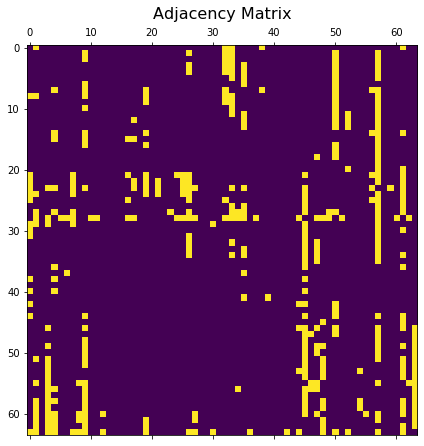

In [10]:
#let's see how the adjacency matrix looks like
f = plt.figure(figsize=(7, 7))
plt.matshow(eo_adj, fignum=f.number)
plt.title('Adjacency Matrix for EO with PDC', fontsize=16);

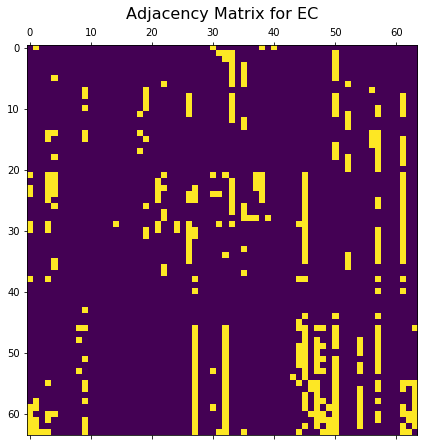

In [15]:
#let's do the same for EC
#fitting in the model for eo with method yule-walker
model = cp.Mvar().fit(ec, method = "yw")

#compute PDC
ec_pdc=cp.conn.pdc_fun(model[0],model[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(ec_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2
n = ec_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-ec_pdc, axis = None)[num_edges+1]

#adj_matrix
ec_adj = (ec_pdc > threshold).astype(int)

#plot the matrix
f = plt.figure(figsize=(7, 7))
plt.matshow(ec_adj, fignum=f.number)
plt.title('Adjacency Matrix for EC with PDC', fontsize=16);

## Question 1.2
let's repeat the same computation but with DTF instead of PDC

C:\Users\giuli\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


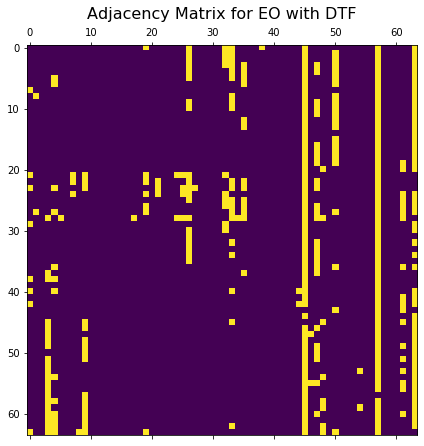

In [16]:
#compute PDC
eo_dtf=cp.conn.dtf_fun(model[0],model[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_dtf,0)

#find our threshold   
threshold = -np.sort(-eo_dtf, axis = None)[num_edges+1]

#adj_matrix
eo_adj = (eo_dtf > threshold).astype(int)

#plot
f = plt.figure(figsize=(7, 7))
plt.matshow(eo_adj, fignum=f.number)
plt.title('Adjacency Matrix for EO with DTF', fontsize=16);

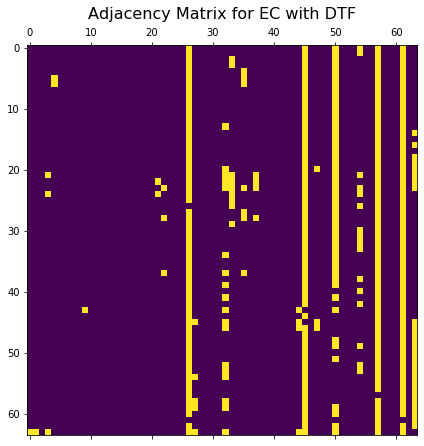

In [18]:
#compute PDC
ec_dtf=cp.conn.dtf_fun(model[0],model[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(ec_dtf,0)

#find our threshold   
threshold = -np.sort(-ec_dtf, axis = None)[num_edges+1]

#adj_matrix
ec_adj = (ec_dtf > threshold).astype(int)

#plot
f = plt.figure(figsize=(7, 7))
plt.matshow(ec_adj, fignum=f.number)
plt.title('Adjacency Matrix for EC with DTF', fontsize=16);

## Question 1.3
let's repeat with different density values

## Question 1.5
we plot the graph down

C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


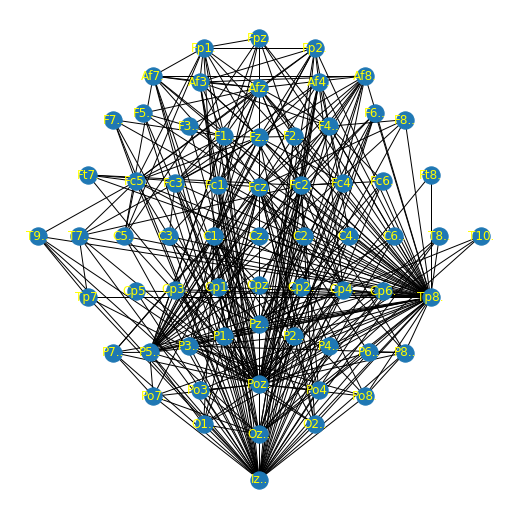

In [19]:
#create the graph
eo_g=nx.from_numpy_matrix(eo_adj)

#we need a dictionary with couples 0...64 and signal labels in order to rename the nodes of the graph
mapping={}
for i in range(len(signal_labels)):
    mapping[i]=signal_labels[i]
mapping


#let's rename them
eo_g=nx.relabel_nodes(eo_g, mapping)

#now give them a location 
#open the location file
position=pd.read_csv('channel_locations.txt', sep='\s+')

#create a pos dictionary to pass the position to the nodes of our graph
pos={}
for i in range(64):
    pos[position['label'][i]]=[position['x'][i],position['y'][i]]

#let's see our graph
f = plt.figure(figsize=(8, 8))
nx.draw(eo_g, pos)
nx.draw_networkx_labels(eo_g, pos=pos, font_color='yellow')
plt.show()

In [14]:
eo.shape

(64, 9760)